In [221]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from mongoengine import *
from urllib.parse import urlparse, parse_qsl
connect('mongoengine_documents')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
sys.path.append('/home/galm/software/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from monary import Monary
mon = Monary()

from scoping.models import *

from mongo_classes import *

In [222]:
# How many comparisons did we make?
print(similarity.objects.count())

91041


In [223]:
# How many scopus docs have been checked? Or did we record?
print(len(similarity.objects.distinct('scopus_id')))

# How many scopus docs are there?
print(scopus_doc.objects.count())

24647
383460


In [224]:
# How many cases do we have in each combination of doi availability
yy = similarity.objects.filter(scopus_do=True,wos_do=True).count()
yn = similarity.objects.filter(scopus_do=True,wos_do=False).count()
ny = similarity.objects.filter(scopus_do=False,wos_do=True).count()
nn = similarity.objects.filter(scopus_do=False,wos_do=False).count()


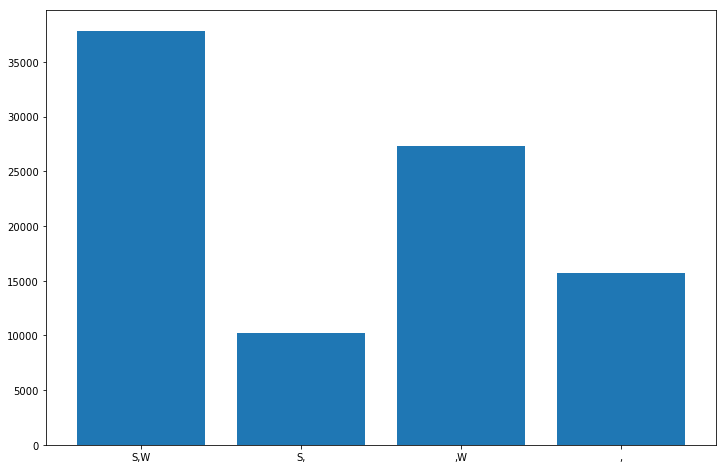

In [225]:
ind = np.arange(4)
vals = [yy,yn,ny,nn]
labels = ['S,W','S,',',W',',']
plt.bar(ind,vals)
plt.xticks(ind,labels)
plt.show()

In [71]:
pipeline = [
    {"$match": {"DO": {"$exists": 1 }}},
    {"$group" : {"_id":"$PY", "count":{"$sum":1}}}
]
do_results = list(scopus_doc.objects.aggregate(*pipeline))

pipeline = [
    {"$match": {"DO": {"$exists": 0 }}},
    {"$group" : {"_id":"$PY", "count":{"$sum":1}}}
]
nodo_results = list(scopus_doc.objects.aggregate(*pipeline))




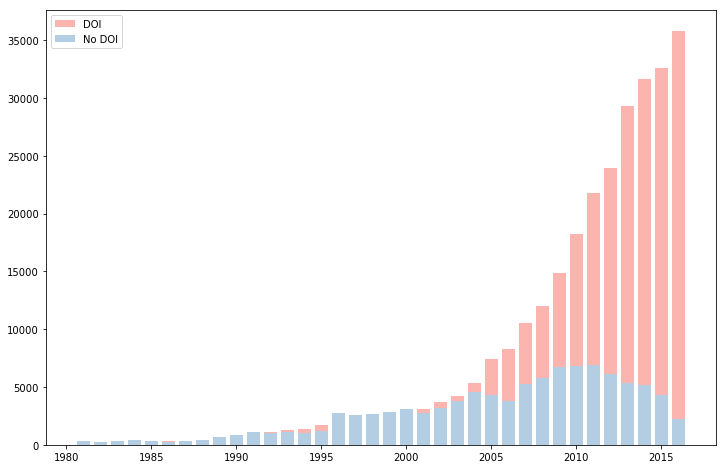

In [72]:
do = pd.DataFrame.from_dict(do_results).rename(index=str,columns={"count": "do_count"})
nodo = pd.DataFrame.from_dict(nodo_results).rename(index=str,columns={"count": "nodo_count"})
bypy = do.merge(nodo)
bypy = bypy[bypy._id>1980]#.reset_index(drop=True)

bypy = bypy.sort_values(by='_id', ascending=1).reset_index(drop=True)

fig_size = [None,None]
fig_size[0] = 12 #width
fig_size[1] = 8 #height
plt.rcParams["figure.figsize"] = fig_size

p1 = plt.bar(bypy._id,bypy['do_count'],color='#fbb4ae')
p2 = plt.bar(bypy._id,bypy['nodo_count'],color='#b3cde3')

plt.legend((p1[0],p2[0]),('DOI','No DOI'))
#plt.savefig('../plots/scopus_docs_do_time.png',bbox_inches='tight')
plt.show()

In [226]:
## Does similarity differ by availability of dois?

#yy = list(similarity.objects.filter(scopus_do=True,wos_do=True).only('jaccard'))

#print(len(yy))

t = similarity.objects.filter(scopus_do=True,wos_do=True)
print(t.count())
tall = t.all()

37865


In [227]:
matches = similarity.objects(Q(jaccard__gt=0.5,py_diff__lt=2) | Q(do_match=True))
mcount = matches.count()
matchest = matches.filter(do_match=False).count()
match_def =  matches.filter(do_match=True).count()

print(matches.count())

20989


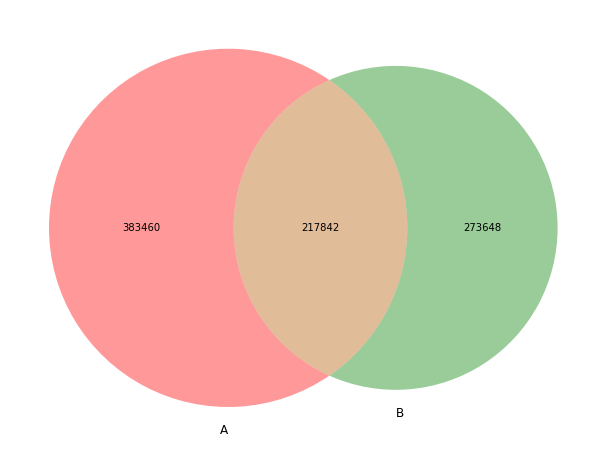

In [148]:
from matplotlib_venn import venn2

wosdocs = Doc.objects.filter(query=365).count()

venn2(subsets = (scopus_doc.objects.count(), wosdocs, 217842))

plt.show()


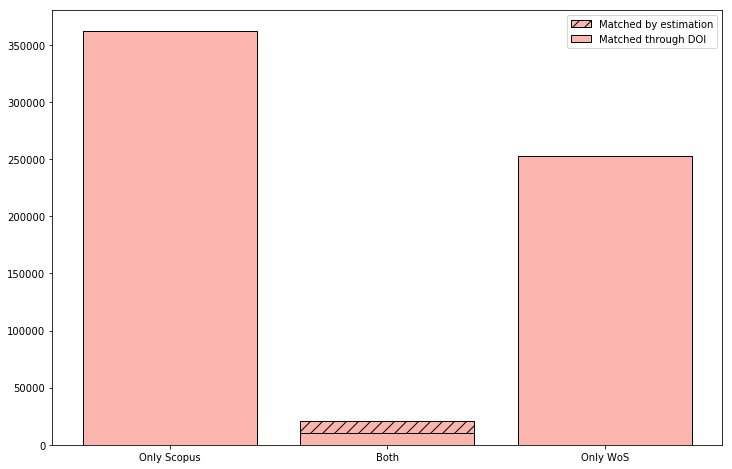

In [228]:
ind = np.arange(3)
os = scopus_doc.objects.count() - mcount

ow = wosdocs - mcount
vals = [os,matchest,ow]
labels = ['Only Scopus','Both','Only WoS']

p1 = plt.bar(ind[1],match_def,color='#fbb4ae',edgecolor='black', hatch="//",bottom=matchest)
p2 = plt.bar(ind,vals,color='#fbb4ae',edgecolor='black')

plt.legend((p1[0],p2[0]),('Matched by estimation','Matched through DOI'))

plt.xticks(ind,labels)
plt.show()

In [150]:
matchest

1523

In [151]:
match_def

1665

In [229]:
columns = ['do_match', 'jaccard', 'wc_diff','wc','t_match']
numpy_arrays = mon.query('mongoengine_documents', 
                        'similarity', 
                        { "scopus_do": True , "wos_do": True},
                        columns, 
                        ['bool', 'float32', 'int8','int8','bool'])

In [230]:
df = np.matrix(numpy_arrays).transpose() 
df = pd.DataFrame(df, columns=columns)
print(df.head())
print(len(df))

   do_match   jaccard  wc_diff    wc  t_match
0       1.0  0.583333      1.0  10.0      0.0
1       1.0  1.000000      0.0   7.0      0.0
2       0.0  0.750000      2.0   8.0      0.0
3       1.0  1.000000      0.0   8.0      0.0
4       1.0  0.176471     20.0  21.0      0.0
37865


In [231]:
from sklearn.linear_model import SGDClassifier
X = df[['jaccard','wc_diff']]
y = df.do_match

clf = SGDClassifier(loss="log", alpha=0.01, n_iter=200, fit_intercept=True)
clf.fit(X, y)

print(clf.score(X,y))



0.950376336987


In [232]:
X = df[['jaccard','wc_diff','wc']]
y = df.do_match

clf = SGDClassifier(loss="log", alpha=0.01, n_iter=200, fit_intercept=True)
clf.fit(X, y)

print(clf.score(X,y))


0.950930938862


In [233]:
df['wcj'] = df.apply(lambda x: x['jaccard'] * x['wc'],axis=1)
df['title_match'] = df.apply(lambda x: np.floor(x['jaccard']), axis=1)
df['thresh_match'] = df["jaccard"] > 0.5
df['thresh_match_2'] = df["jaccard"] > 0.47

print(df.head())

X = df[['jaccard','wc_diff','wc','wcj']]
y = df.do_match

clf = SGDClassifier(loss="log", alpha=0.01, n_iter=200, fit_intercept=True)
clf.fit(X, y)

print(clf.score(X,y))

   do_match   jaccard  wc_diff    wc  t_match       wcj  title_match  \
0       1.0  0.583333      1.0  10.0      0.0  5.833333          0.0   
1       1.0  1.000000      0.0   7.0      0.0  7.000000          1.0   
2       0.0  0.750000      2.0   8.0      0.0  6.000000          0.0   
3       1.0  1.000000      0.0   8.0      0.0  8.000000          1.0   
4       1.0  0.176471     20.0  21.0      0.0  3.705883          0.0   

  thresh_match thresh_match_2  
0         True           True  
1         True           True  
2         True           True  
3         True           True  
4        False          False  
0.961521193715


In [234]:
df_train = df.sample(frac=0.5, replace=True)
df_test = df.sample(frac=0.2, replace=True)

X_train = df_train[['jaccard','wc_diff','wc','wcj','title_match']]
y_train = df_train.do_match

X_test = df_test[['jaccard','wc_diff','wc','wcj','title_match']]
y_test = df_test.do_match

clf = SGDClassifier(loss="hinge", alpha=0.03, n_iter=20000, fit_intercept=True)
clf.fit(X_train, y_train)

print(clf.score(X_test,y_test))


0.966855935561


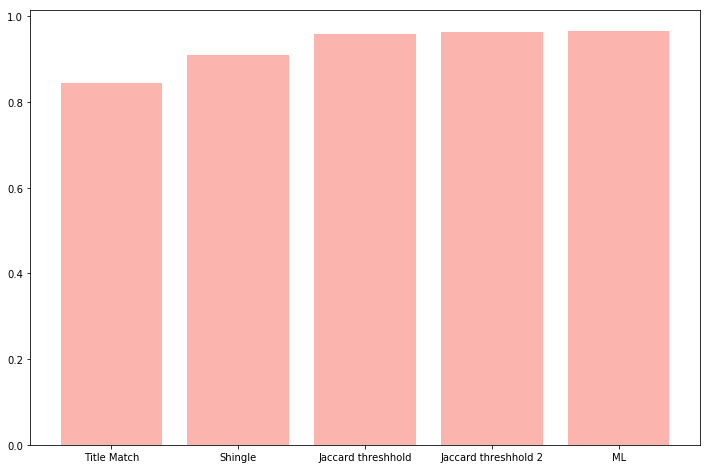

In [235]:
from sklearn.metrics import accuracy_score

y_hat = clf.predict(X_test)
l1 = accuracy_score(y_test,y_hat) 

s1 = accuracy_score(y_test,df_test['title_match'])
n1 = accuracy_score(y_test,df_test['t_match'])





t1 = accuracy_score(y_test,df_test['thresh_match'])
t2 = accuracy_score(y_test,df_test['thresh_match_2'])

ind = np.arange(5)

vals = [n1,s1,t1,t2,l1]
labels = ['Title Match','Shingle','Jaccard threshhold','Jaccard threshhold 2','ML']

plt.bar(ind,vals,color='#fbb4ae')

plt.xticks(ind,labels)
plt.show()

#naive_score = 

In [162]:
coefs = clf.coef_

print(coefs)

print(clf.intercept_)

#print(clf.decision_function([[2,2]]))



[[ 0.31423919 -0.09847047 -0.10061113  0.60493515 -0.182432  ]]
[-1.01473257]


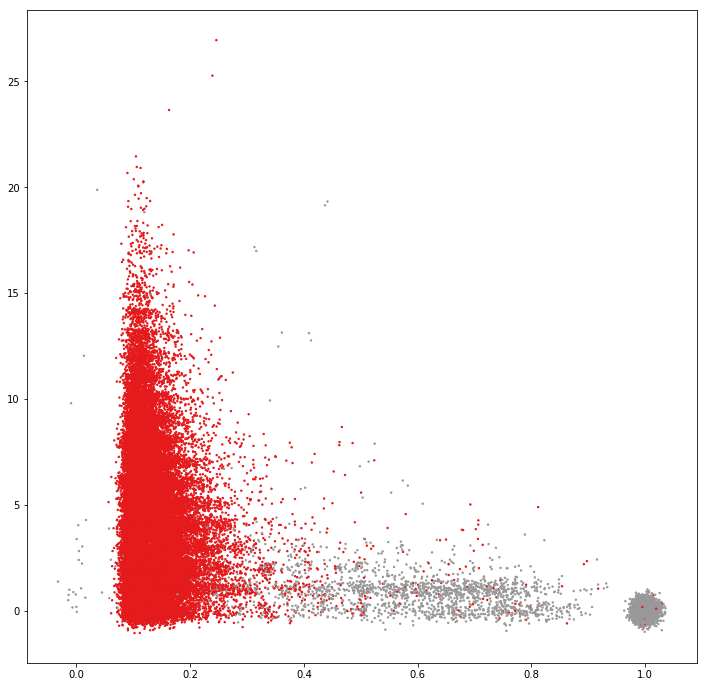

In [231]:
pdf = df.sample(frac=0.5, replace=True)

fig_size = [None,None]
fig_size[0] = 12
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, verts=verts, hold=hold, **kwargs)

jitter(pdf.jaccard, pdf.wc_diff, c=pdf.do_match,s=2, cmap='Set1')

plt.show()

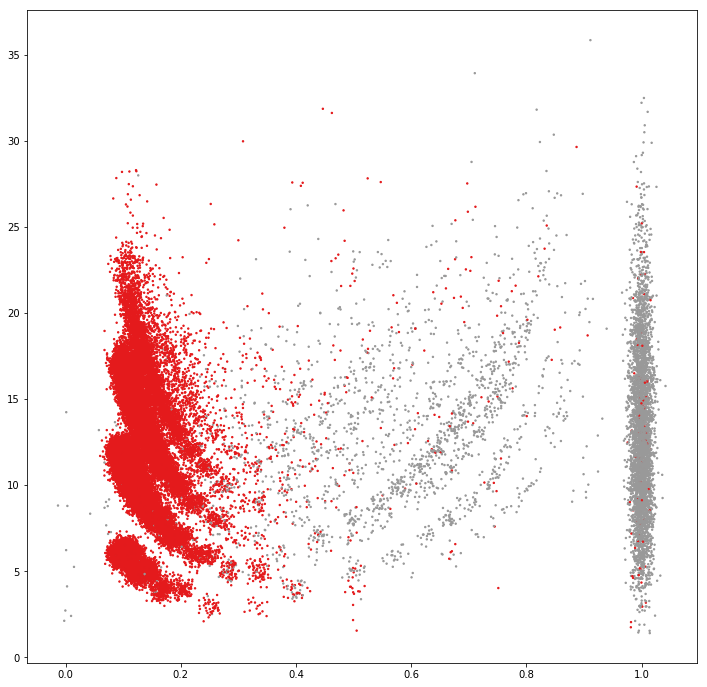

In [230]:
jitter(pdf.jaccard, pdf.wc, c=pdf.do_match,s=2, cmap='Set1')

plt.show()

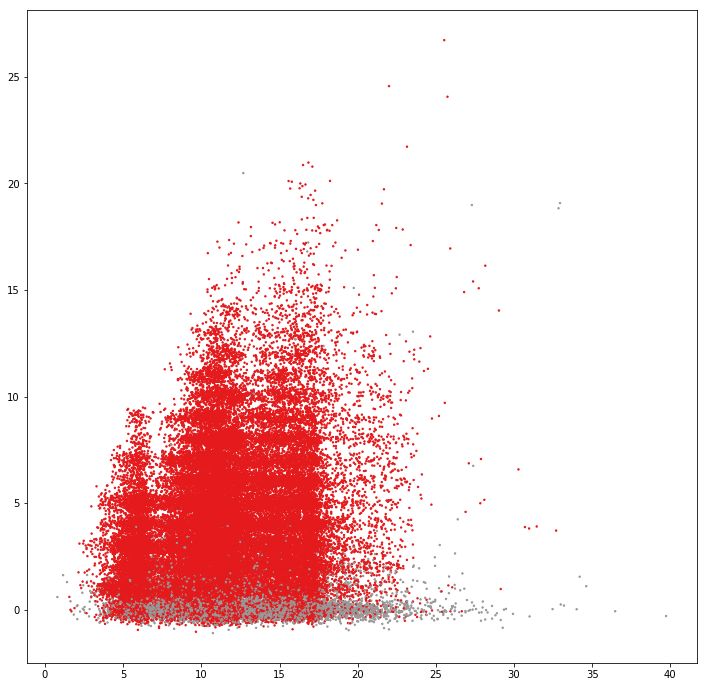

In [233]:
jitter(pdf.wc, pdf.wc_diff, c=pdf.do_match,s=2, cmap='Set1')

plt.show()

In [105]:
similarity.objects.count()

0